# Syntactic Pattern Aspect-Based Sentiment Analysis (SP-ABSA)
## A Reproducible Implementation for Customer Feedback Analysis

This notebook provides a complete implementation of the SP-ABSA methodology. It uses spaCy for linguistic analysis and a Hugging Face Transformer model for context-aware sentiment classification.

Methodology Overview:

   * Syntactic Parsing: A sentence is parsed to identify grammatical relationships between words.

   * Pattern Matching: The parsed sentence is scanned for four predefined syntactic patterns that commonly express opinions.

   * Triplet Extraction: For each matched pattern, an (Aspect, Attribute, Sentiment) triplet is extracted.

   * Sentiment Analysis: A two-stage sentiment analysis is performed to determine the polarity for each extracted attribute.

spaCy model 'en_core_web_lg' loaded successfully.
VADER sentiment analyzer loaded successfully.

Successfully parsed 906 sentences with triplet annotations.

Building aspect lexicon from raw sentences (unsupervised)...


1/3 Extracting Noun Chunks:   0%|          | 0/906 [00:00<?, ?it/s]

2/3 Clustering Terms:   0%|          | 0/1171 [00:00<?, ?it/s]

3/3 Finalizing Lexicon...
Unsupervised lexicon created with 732 canonical aspect terms.


Evaluating SP-ABSA V4 (Lexicon-driven):   0%|          | 0/906 [00:00<?, ?it/s]

Evaluating Dep-Rule Baseline:   0%|          | 0/906 [00:00<?, ?it/s]


                         --- Quantitative Results on Triplet Extraction ---                         
            --- (Partial Matching for Aspect/Attribute + Exact Match for Sentiment) ---             
                      Model  TP   FP   FN Precision Recall F1-Score
SP-ABSA V4 (Lexicon-driven) 323  505 1133     0.390  0.222    0.283
          Dep-Rule Baseline 252 1036 1204     0.196  0.173    0.184

*Evaluation based on 906 reviews.

Analyzing full dataset with the final model (SP-ABSA V4)...


Processing Reviews with V4 Model:   0%|          | 0/906 [00:00<?, ?it/s]

Analysis complete. DataFrame for V4 model created.


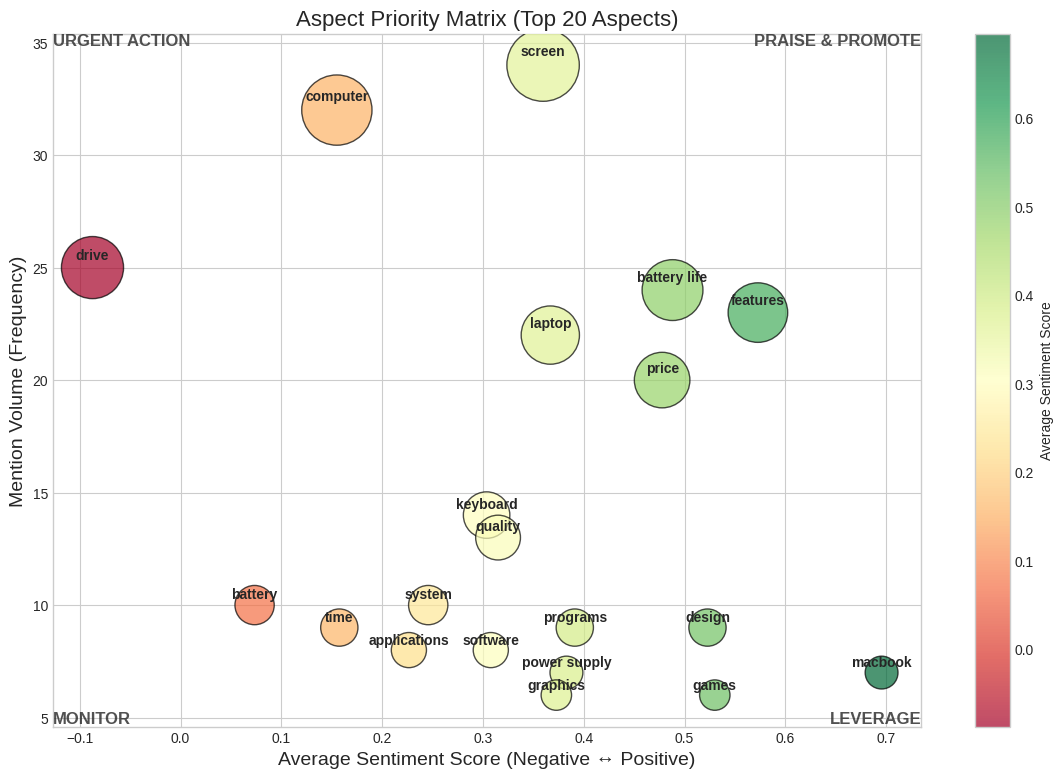

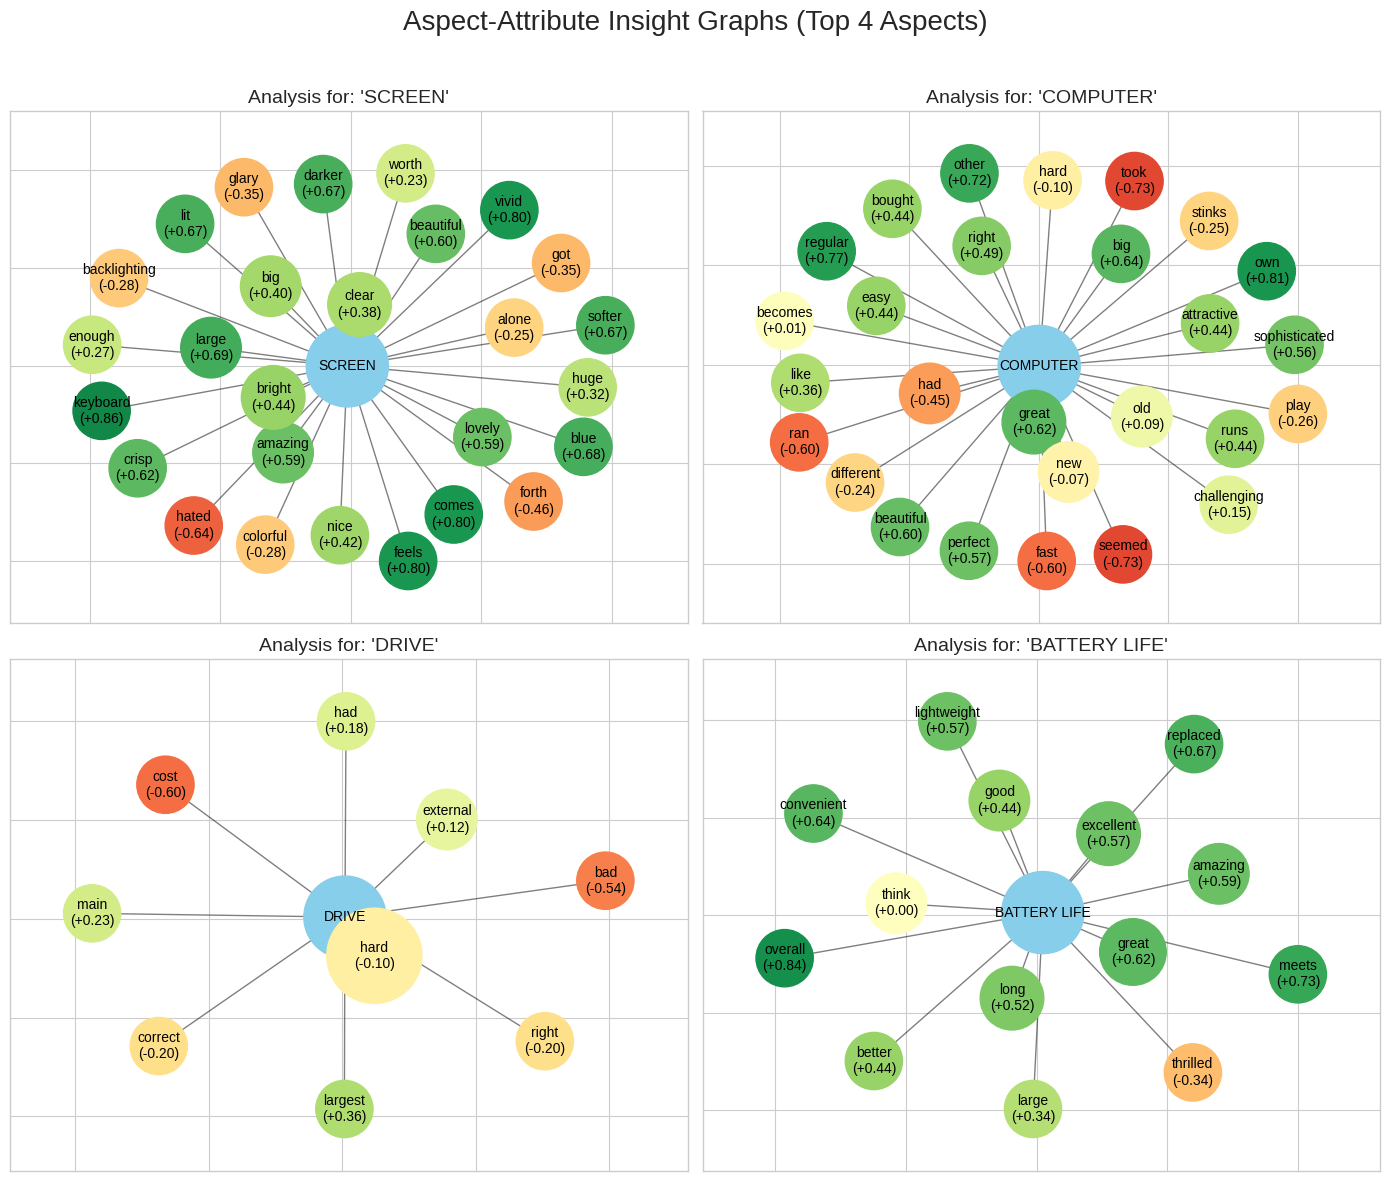

In [2]:
# ==============================================================================
# Section 1: Setup and Initialization
# ==============================================================================
# All imports and model initializations are consolidated here for clarity.

import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Token
from transformers import pipeline, logging as hf_logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import re
import ast
from collections import Counter
from tqdm.notebook import tqdm
from typing import List, Tuple, Callable, Dict, Any, Set
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import math

# --- Initialize Models and Tools ---

# Suppress verbose informational messages from the Hugging Face transformers library.
hf_logging.set_verbosity_error()

# Load the spaCy model
try:
    nlp = spacy.load("en_core_web_lg")
    print("spaCy model 'en_core_web_lg' loaded successfully.")
except OSError:
    print("Downloading 'en_core_web_lg' model...")
    spacy.cli.download("en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")

# Initialize the VADER sentiment analyzer
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    print("Downloading VADER lexicon for the first time...")
    nltk.download('vader_lexicon', quiet=True)
vader_analyzer = SentimentIntensityAnalyzer()
print("VADER sentiment analyzer loaded successfully.")


# ==============================================================================
# Section 2: Helper Functions
# ==============================================================================
# Consolidated helper functions for text cleaning, sentiment analysis, etc.

def _clean_text(text: str) -> str:
    """Encapsulates all text cleaning operations."""
    cleaned_text = str(text).lower()
    cleaned_text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

def _is_negated(token: Token) -> bool:
    """Robustly checks if a token is negated by checking its children or its head's children."""
    if any(c.dep_ == 'neg' for c in token.children):
        return True
    if any(c.dep_ == 'neg' for c in token.head.children):
        return True
    return False

def _get_vader_sentiment_with_score(attribute_text: str, full_context: str, is_negated: bool) -> Tuple[str, float]:
    """
    Performs a two-stage, lexicon-based sentiment analysis using VADER.
    Stage 1: Analyzes the attribute word/phrase, including explicit negation.
    Stage 2: If the attribute is neutral, the full sentence context is used to disambiguate.
    """
    text_to_analyze = f"not {attribute_text}" if is_negated else attribute_text
    attr_scores = vader_analyzer.polarity_scores(text_to_analyze)
    compound_score = attr_scores['compound']

    # Stage 2: Use context for disambiguation if the attribute is neutral
    if -0.05 < compound_score < 0.05:
        context_scores = vader_analyzer.polarity_scores(full_context)
        if abs(context_scores['compound']) > abs(compound_score):
            compound_score = context_scores['compound']

    if compound_score >= 0.05:
        final_label = 'positive'
    elif compound_score <= -0.05:
        final_label = 'negative'
    else:
        final_label = 'neutral'
    return final_label, compound_score


# ==============================================================================
# Section 3: Data Loading & Unsupervised Lexicon Creation
# ==============================================================================
# CONSOLIDATED: Using a single, robust data parser.

def parse_triplet_dataset(filepath: str) -> List[Dict[str, Any]]:
    """
    Parses the .txt file with triplet annotations, reconstructing phrases from word indices.
    This is the consolidated and robust version.
    """
    dataset = []
    sentiment_map = {'POS': 'positive', 'NEG': 'negative', 'NEU': 'neutral'}
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                if '####' not in line:
                    continue
                text_part, label_part = line.strip().split('####')
                tokens = text_part.split()
                try:
                    labels = ast.literal_eval(label_part)
                    reconstructed_truths = []
                    for label_tuple in labels:
                        if len(label_tuple) != 3:
                            continue
                        aspect_indices, opinion_indices, sentiment_str = label_tuple
                        aspect_words = [tokens[i] for i in sorted(aspect_indices) if i < len(tokens)]
                        opinion_words = [tokens[i] for i in sorted(opinion_indices) if i < len(tokens)]
                        if aspect_words and opinion_words:
                            aspect_text = " ".join(aspect_words).lower()
                            attribute_text = " ".join(opinion_words).lower()
                            standard_sentiment = sentiment_map.get(sentiment_str, 'neutral')
                            reconstructed_truths.append((aspect_text, attribute_text, standard_sentiment))
                    if reconstructed_truths:
                        dataset.append({'sentence': text_part, 'ground_truths': reconstructed_truths})
                except (ValueError, SyntaxError, IndexError):
                    print(f"Warning: Could not parse labels on line {line_num}. Skipping.")
                    continue
    except FileNotFoundError:
        print(f"Error: The file '{filepath}' was not found.")
        return []
    return dataset

def create_aspect_lexicon_from_text(sentences: List[str], similarity_threshold: float = 0.85) -> Dict[str, List[str]]:
    """Unsupervisedly extracts noun chunks, clusters them, and builds an aspect lexicon."""
    print("\nBuilding aspect lexicon from raw sentences (unsupervised)...")
    candidate_aspects = []
    stop_words = nlp.Defaults.stop_words
    generic_terms = {'product', 'thing', 'stuff', 'item', 'lot', 'part', 'bit', 'way'}

    docs = nlp.pipe(sentences, n_process=-1)
    for doc in tqdm(docs, total=len(sentences), desc="1/3 Extracting Noun Chunks"):
        for chunk in doc.noun_chunks:
            core_tokens = [tok for tok in chunk if tok.pos_ in {'NOUN', 'PROPN'}]
            if core_tokens:
                core_aspect = " ".join(tok.text for tok in core_tokens).lower()
                if core_aspect not in stop_words and core_aspect not in generic_terms:
                    candidate_aspects.append(core_aspect)

    if not candidate_aspects:
        return {}

    aspect_counts = Counter(candidate_aspects)
    unique_aspects = sorted(aspect_counts.keys(), key=lambda x: aspect_counts[x], reverse=True)
    aspect_docs = {text: nlp(text) for text in unique_aspects}

    clusters, processed_aspects = [], set()
    for aspect in tqdm(unique_aspects, desc="2/3 Clustering Terms"):
        if aspect in processed_aspects:
            continue
        current_cluster = {aspect}
        doc1 = aspect_docs[aspect]
        for other_aspect in unique_aspects:
            if other_aspect in processed_aspects or other_aspect == aspect:
                continue
            doc2 = aspect_docs[other_aspect]
            is_similar = (doc1.vector_norm and doc2.vector_norm and doc1.similarity(doc2) > similarity_threshold)
            is_substring = (len(aspect.split()) > 1 or len(other_aspect.split()) > 1) and \
                           (aspect in other_aspect or other_aspect in aspect)
            if is_similar or is_substring:
                current_cluster.add(other_aspect)

        processed_aspects.update(current_cluster)
        clusters.append(list(current_cluster))

    aspect_lexicon = {}
    print("3/3 Finalizing Lexicon...")
    for cluster in clusters:
        canonical_key = max(cluster, key=lambda x: aspect_counts.get(x, 0))
        aspect_lexicon[canonical_key] = sorted(list(set(cluster)))

    print(f"Unsupervised lexicon created with {len(aspect_lexicon)} canonical aspect terms.")
    return aspect_lexicon


# ==============================================================================
# Section 4: Unified High-Precision Pattern Checkers
# ==============================================================================
# REFACTORED: The logic from V1 has been formalized into these reusable checkers.

PatternChecker = Callable[[Token, Token], bool]

# --- Core Verb-Centric Patterns ---
def check_nva_acomp(aspect: Token, attr: Token) -> bool:
    """Checks for Noun-Verb-Adjective (e.g., "The [screen] is [great]")."""
    return (attr.dep_ == 'acomp' and
            attr.head.pos_ in ["VERB", "AUX"] and
            aspect.head == attr.head and
            aspect.dep_ in ["nsubj", "nsubjpass"])

def check_van_amod(aspect: Token, attr: Token) -> bool:
    """Checks for Verb-Adjective-Noun (e.g., "It is a [great] [screen]")."""
    return (aspect.dep_ in ["attr", "pobj", "dobj"] and
            attr.dep_ == 'amod' and
            attr.head == aspect)

def check_conjoined_attribute(aspect: Token, attr: Token) -> bool:
    """Checks for conjoined attributes (e.g., "screen is bright and [clear]")."""
    if attr.dep_ != 'conj':
        return False
    first_attribute = attr.head
    if first_attribute.head.pos_ not in ["VERB", "AUX"]:
        return False
    verb_token = first_attribute.head
    return (aspect.dep_ in ['nsubj', 'nsubjpass'] and aspect.head == verb_token)

# --- Core Verbless Patterns ---
def check_verbless_an_na(aspect: Token, attr: Token) -> bool:
    """Checks for verbless Noun-Adjective fragments (e.g., "[Great] [screen].")."""
    return (attr.dep_ == 'amod' and
            attr.head == aspect and
            aspect.sent.root.pos_ in ["NOUN", "PROPN"])

# --- Master List of Pattern Checkers ---
PATTERN_CHECKERS: List[Tuple[str, PatternChecker]] = [
    ("NVA/AVN (acomp)", check_nva_acomp),
    ("VAN (amod)", check_van_amod),
    ("Conjoined_Attribute", check_conjoined_attribute),
    ("NA/AN (verbless)", check_verbless_an_na),
]


# ==============================================================================
# Section 5: Core SP-ABSA Logic (Final Version)
# ==============================================================================
# REMOVED: sp_absa_analysis_with_scores_v1.
# This is the final, lexicon-driven model which is more accurate and robust.

def sp_absa_analysis_with_lexicon_v4(text: str, aspect_lexicon: Dict[str, List[str]]) -> List[Dict]:
    """
    Main orchestrator function for SP-ABSA, using a pre-built aspect lexicon.
    This version is corrected to handle spaCy Matcher indexing robustly.
    """
    cleaned_text = _clean_text(text)
    if pd.isna(cleaned_text) or not cleaned_text or not aspect_lexicon:
        return []

    matcher = PhraseMatcher(nlp.vocab, attr='LOWER')
    patterns = [nlp.make_doc(term) for terms_list in aspect_lexicon.values() for term in terms_list]
    if not patterns:
        return []
    matcher.add("AspectTerms", patterns)

    all_triplets = []
    doc = nlp(cleaned_text)
    matches = matcher(doc)

    processed_pairs: Set[Tuple[int, int]] = set()

    for sent in doc.sents:
        # Filter matches to only those within the current sentence's span
        spans_in_sent = [doc[start:end] for match_id, start, end in matches if start >= sent.start and end <= sent.end]
        if not spans_in_sent:
            continue

        candidate_attributes = [tok for tok in sent if tok.pos_ in {"ADJ", "ADV", "VERB", "NOUN"}]

        for aspect_span in spans_in_sent:
            aspect_root = aspect_span.root
            for attr in candidate_attributes:
                if aspect_root.i == attr.i or (aspect_root.i, attr.i) in processed_pairs:
                    continue

                for pattern_name, checker_func in PATTERN_CHECKERS:
                    if checker_func(aspect_root, attr):
                        negated = _is_negated(attr)
                        label, score = _get_vader_sentiment_with_score(attr.text, sent.text, negated)

                        # Avoid neutral opinions unless they are negated
                        if label == 'neutral' and not negated:
                            continue

                        all_triplets.append({
                            "aspect": aspect_span.text.lower(),
                            "attribute": attr.text.lower(),
                            "sentiment": label,
                            "score": score,
                            "pattern": pattern_name,
                            "negated": negated
                        })
                        processed_pairs.add((aspect_root.i, attr.i))
                        break # Move to the next attribute after finding a pattern

    # De-duplicate results
    unique_triplets = []
    seen_keys = set()
    for triplet in all_triplets:
        key = (triplet['aspect'], triplet['attribute'], triplet['sentiment'])
        if key not in seen_keys:
            unique_triplets.append(triplet)
            seen_keys.add(key)

    return unique_triplets

def _get_full_aspect_phrase(token):
    """
    Expands a noun token to its full compound phrase (e.g., 'battery life').
    """
    parts = [child for child in token.children if child.dep_ == "compound" and child.i < token.i]
    parts.append(token)
    parts.sort(key=lambda t: t.i)
    return " ".join([p.text for p in parts]).lower()


# Baseline model for comparison
def dep_rule_baseline_analysis(text):
    """
    A simpler, classic dependency-based rule system.
    It looks for two common patterns:
    1. Subject -> is -> Adjective (nsubj -> an_aux -> acomp)
    2. Adjective -> Noun (amod)
    """
    if pd.isna(text):
        return []

    doc = nlp(str(text).lower())
    triplets = []

    for token in doc:
        # Pattern 1: Subject is Adjective (e.g., "screen is bright")
        if token.dep_ == 'acomp' and token.head.pos_ == 'AUX':
            subjects = [child for child in token.head.children if child.dep_ == 'nsubj']
            if subjects:
                aspect = _get_full_aspect_phrase(subjects[0])
                attribute = token.text
                sentiment_scores = vader_analyzer.polarity_scores(attribute)

                if sentiment_scores['compound'] > 0.05:
                    sentiment = 'positive'
                elif sentiment_scores['compound'] < -0.05:
                    sentiment = 'negative'
                else:
                    sentiment = 'neutral'

                triplets.append({'aspect': aspect, 'attribute': attribute, 'sentiment': sentiment})

        # Pattern 2: Adjectival modifier (e.g., "a good screen")
        if token.dep_ == 'amod':
            aspect = _get_full_aspect_phrase(token.head)
            attribute = token.text
            sentiment_scores = vader_analyzer.polarity_scores(attribute)

            if sentiment_scores['compound'] > 0.05:
                sentiment = 'positive'
            elif sentiment_scores['compound'] < -0.05:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'

            triplets.append({'aspect': aspect, 'attribute': attribute, 'sentiment': sentiment})

    return triplets
# def dep_rule_baseline_analysis(text: str) -> list:
#     """A simpler, classic dependency-based rule system for baseline comparison."""
#     if pd.isna(text):
#         return []
#     doc = nlp(str(text).lower())
#     triplets = []
#     for token in doc:
#         # Pattern 1: Subject is Adjective
#         if token.dep_ == 'acomp' and token.head.pos_ == 'AUX':
#             subjects = [child for child in token.head.children if child.dep_ == 'nsubj']
#             if subjects:
#                 label, _ = _get_vader_sentiment_with_score(token.text, token.sent.text, _is_negated(token))
#                 triplets.append({'aspect': subjects[0].text, 'attribute': token.text, 'sentiment': label})
#         # Pattern 2: Adjectival modifier
#         if token.dep_ == 'amod':
#             label, _ = _get_vader_sentiment_with_score(token.text, token.sent.text, _is_negated(token))
#             triplets.append({'aspect': token.head.text, 'attribute': token.text, 'sentiment': label})
#     return triplets


# ==============================================================================
# Section 6: Evaluation Pipeline
# ==============================================================================
# REFACTORED: Using the improved evaluation logic with partial matching.
# The old run_full_evaluation is removed.

def evaluate_with_partial_matching(predicted_triplets: set, true_triplets: set) -> dict:
    """
    Evaluates triplets with partial matching for aspect/attribute and exact for sentiment.
    Returns counts for TP, FP, FN.
    """
    matched_true_indices = [False] * len(true_triplets)
    tp, fp = 0, 0

    pred_list = list(predicted_triplets)
    true_list = list(true_triplets)

    for pred_aspect, pred_attr, pred_sent in pred_list:
        is_match_found = False
        for j, (true_aspect, true_attr, true_sent) in enumerate(true_list):
            if matched_true_indices[j]:
                continue

            # Partial match for aspect/attribute, exact for sentiment
            if (pred_aspect in true_aspect or true_aspect in pred_aspect) and \
               (pred_attr in true_attr or true_attr in true_attr) and \
               (pred_sent == true_sent):
                matched_true_indices[j] = True
                is_match_found = True
                break

        if is_match_found:
            tp += 1
        else:
            fp += 1

    fn = matched_true_indices.count(False)
    return {"tp": tp, "fp": fp, "fn": fn}

def evaluate_model(model_func: Callable, evaluation_data: list, model_name: str, aspect_lexicon: dict = None) -> dict:
    """Unified model evaluation function."""
    total_tp, total_fp, total_fn = 0, 0, 0

    for item in tqdm(evaluation_data, desc=f"Evaluating {model_name}"):
        true_triplets = set(item['ground_truths'])

        # Handle function arguments for different models
        if "V4" in model_name:
            predictions_raw = model_func(item['sentence'], aspect_lexicon=aspect_lexicon)
        else: # Baseline
            predictions_raw = model_func(item['sentence'])

        predicted_triplets = {(p['aspect'], p['attribute'], p['sentiment']) for p in predictions_raw}

        eval_results = evaluate_with_partial_matching(predicted_triplets, true_triplets)
        total_tp += eval_results['tp']
        total_fp += eval_results['fp']
        total_fn += eval_results['fn']

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "model_name": model_name, "tp": total_tp, "fp": total_fp, "fn": total_fn,
        "precision": precision, "recall": recall, "f1_score": f1
    }

def display_results(results: list, num_reviews: int):
    """Formats and prints the evaluation results in a clean table."""
    report_data = [{
        'Model': res['model_name'],
        'TP': res['tp'], 'FP': res['fp'], 'FN': res['fn'],
        'Precision': f"{res['precision']:.3f}",
        'Recall': f"{res['recall']:.3f}",
        'F1-Score': f"{res['f1_score']:.3f}"
    } for res in results]

    df_results = pd.DataFrame(report_data)
    print("\n" + "="*100)
    print("--- Quantitative Results on Triplet Extraction ---".center(100))
    print("--- (Partial Matching for Aspect/Attribute + Exact Match for Sentiment) ---".center(100))
    print("="*100)
    print(df_results.to_string(index=False))
    print(f"\n*Evaluation based on {num_reviews} reviews.")


# ==============================================================================
# Section 7: Visualizations
# ==============================================================================
# CONSOLIDATED: Keeping the enhanced and more functional versions of the plots.

def visualize_priority_matrix(df: pd.DataFrame, top_x: int = None, label_threshold: int = 5):
    """
    Creates an enhanced 2x2 matrix plotting aspects by mention frequency vs. average
    sentiment, with conditional labeling to prevent overlap.
    """
    if df.empty:
        print("The DataFrame is empty. Cannot generate a plot.")
        return

    aspect_summary = df.groupby('aspect').agg(
        volume=('sentiment', 'count'),
        avg_sentiment=('score', 'mean')
    ).reset_index()

    if top_x and isinstance(top_x, int) and top_x > 0:
        aspect_summary = aspect_summary.nlargest(top_x, 'volume')

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 9))

    scatter = ax.scatter(
        aspect_summary['avg_sentiment'], aspect_summary['volume'],
        s=aspect_summary['volume'] * 80,
        c=aspect_summary['avg_sentiment'],
        cmap='RdYlGn', edgecolor='black', alpha=0.7, zorder=10
    )

    for i, row in aspect_summary.iterrows():
        if row['volume'] >= label_threshold:
            offset = (row['volume']**0.5) * 0.05
            ax.text(row['avg_sentiment'], row['volume'] + offset, row['aspect'],
                    ha='center', va='bottom', fontsize=10, weight='bold', zorder=11)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.text(xmax, ymax, "PRAISE & PROMOTE", ha='right', va='top', fontsize=12, weight='bold', alpha=0.8)
    ax.text(xmin, ymax, "URGENT ACTION", ha='left', va='top', fontsize=12, weight='bold', alpha=0.8)
    ax.text(xmax, ymin, "LEVERAGE", ha='right', va='bottom', fontsize=12, weight='bold', alpha=0.8)
    ax.text(xmin, ymin, "MONITOR", ha='left', va='bottom', fontsize=12, weight='bold', alpha=0.8)

    ax.set_xlabel('Average Sentiment Score (Negative ↔ Positive)', fontsize=14)
    ax.set_ylabel('Mention Volume (Frequency)', fontsize=14)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Sentiment Score')
    plt.title(f'Aspect Priority Matrix (Top {top_x} Aspects)' if top_x else 'Aspect Priority Matrix (All Aspects)', fontsize=16)
    plt.show()

def visualize_aspect_attributes(df: pd.DataFrame, top_x: int = 4):
    """Creates a dynamic grid of cellular graphs for the top X major aspects."""
    if df.empty or top_x == 0:
        print("No aspects to display.")
        return

    grouped = df.groupby(['aspect', 'attribute']).agg(
        frequency=('sentiment', 'count'),
        avg_score=('score', 'mean')
    ).reset_index()

    all_aspects = df['aspect'].value_counts()
    num_to_display = min(top_x, len(all_aspects))
    top_aspects = all_aspects.nlargest(num_to_display).index

    ncols = math.ceil(math.sqrt(num_to_display))
    nrows = math.ceil(num_to_display / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 7, nrows * 6))
    axes = np.array(axes).flatten()

    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=-1.0, vmax=1.0)

    for i, aspect in enumerate(top_aspects):
        ax = axes[i]
        aspect_data = grouped[grouped['aspect'] == aspect]

        G = nx.Graph()
        G.add_node(aspect, size=3500, type='aspect')

        for _, row in aspect_data.iterrows():
            attr, freq = row['attribute'], row['frequency']
            G.add_node(attr, size=1500 + freq * 200, type='attribute')
            G.add_edge(aspect, attr, weight=freq)

        pos = nx.spring_layout(G, seed=42, k=0.9)
        node_sizes = [d['size'] for n, d in G.nodes(data=True)]

        attribute_scores = aspect_data.set_index('attribute')['avg_score'].to_dict()
        node_colors = ['skyblue' if data['type'] == 'aspect' else cmap(norm(attribute_scores.get(node, 0.0)))
                       for node, data in G.nodes(data=True)]

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)

        custom_labels = {node: node.upper() if data['type'] == 'aspect' else f"{node}\n({attribute_scores.get(node, 0.0):+.2f})"
                         for node, data in G.nodes(data=True)}
        nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=10, ax=ax)

        ax.set_title(f"Analysis for: '{aspect.upper()}'", fontsize=14)
        ax.margins(0.1)

    for i in range(len(top_aspects), len(axes)):
        axes[i].set_visible(False)

    plt.suptitle(f"Aspect-Attribute Insight Graphs (Top {num_to_display} Aspects)", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ==============================================================================
# Section 8: Main Execution Block
# ==============================================================================

def main():
    """Main function to run the entire pipeline."""
    FILE_PATH = 'train_triplets.txt'

    # 1. Load Ground Truth Data
    sentences_and_truths = parse_triplet_dataset(FILE_PATH)
    if not sentences_and_truths:
        print("\nExecution stopped: Could not load ground truth data.")
        return
    print(f"\nSuccessfully parsed {len(sentences_and_truths)} sentences with triplet annotations.")

    all_sentences = [item['sentence'] for item in sentences_and_truths]

    # 2. Create Aspect Lexicon Unsupervisedly
    ASPECT_LEXICON = create_aspect_lexicon_from_text(all_sentences)

    # 3. Evaluate Models
    models_to_evaluate = {
        "SP-ABSA V4 (Lexicon-driven)": sp_absa_analysis_with_lexicon_v4,
        "Dep-Rule Baseline": dep_rule_baseline_analysis
    }

    all_results = []
    for name, func in models_to_evaluate.items():
        result = evaluate_model(func, sentences_and_truths, name, aspect_lexicon=ASPECT_LEXICON)
        all_results.append(result)

    display_results(all_results, len(sentences_and_truths))

    # 4. Run Analysis and Visualization on the best model
    print("\nAnalyzing full dataset with the final model (SP-ABSA V4)...")
    all_triplets_v4 = []
    for sentence in tqdm(all_sentences, desc="Processing Reviews with V4 Model"):
        triplets = sp_absa_analysis_with_lexicon_v4(sentence, ASPECT_LEXICON)
        all_triplets_v4.extend(triplets)

    df_v4 = pd.DataFrame(all_triplets_v4)
    print("Analysis complete. DataFrame for V4 model created.")

    # 5. Generate Visualizations
    if not df_v4.empty:
        visualize_priority_matrix(df_v4)#, top_x=20)
        visualize_aspect_attributes(df_v4)#, top_x=4)
    else:
        print("\nNo triplets were extracted by the V4 model, skipping visualization.")

if __name__ == "__main__":
    main()